# **ANALYSIS OF MATCH OUTCOUMES ACROSS THE MAJOR EUROPEAN SOCCER LEAGUES**

### **Table of Contents**
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul

<a id='intro'></a>
## **Introduction**

The aim of the project is to analyse the European Soccer Dataset (available on Kaggle https://www.kaggle.com/hugomathien/soccer/home)
containing results of matches played from 2008 to 2016 across the major european leagues and answering the following questions:

- How is the amount of goal scored distributed? How is it evolving?

- In which leagues are matches most likely to end up with three or more goal?

- Which teams have scored the most?

- Has european football become more or less equilibrated?

- Which are the most equilibrated leagues?

- Is there any evidence of home advantage?

As a measure of competitiveness it has been chosen the difference of the goals scored by the two teams. If the such difference is low, the match is assumed to be more equilibrated. Hence, if a league shows a low goal difference for each match, it is assumed to be more equilibrated and unpredictable.

The final question is aimed to show if during the seasons from 2008 and 2016 it has been a substantial home advantage. The home advantage is defined as the benefit that the home team is said to gain over the visiting team (https://en.wikipedia.org/wiki/Home_advantage) and it may be due to many different factors that we are not takining into consideration in this analysis. The main goal here is to find ou whether or not there had been evidence of home advantage during the perion under analysis.

<a id='wrangling'></a>
## **Data Wrangling**

In [28]:
#Importing libraries and setting plotstyle.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
plt.style.use('seaborn-darkgrid')
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(12,6)})

Before analyzing the data we need to extract them from the database. In order to do so we need to:

1. Establish a connection to the data base;

2. Write SQL queries to extract them, since the data is stored in a SQL database.

In [2]:
# 1. Establish a connection to database.
conn=sqlite3.connect('database.sqlite')

# 2. Query needed data.
match_data=pd.read_sql_query('select league_id, season, date, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal from Match;', conn, parse_dates=True)
league_data=pd.read_sql_query('select id, name AS league from League;', conn)
team_data=pd.read_sql_query('select team_api_id, team_long_name from Team;', conn)

The next step is to check if datatypes are correct and if any data is missing.

In [3]:
match_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 7 columns):
league_id           25979 non-null int64
season              25979 non-null object
date                25979 non-null object
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.4+ MB


In [4]:
league_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id        11 non-null int64
league    11 non-null object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [5]:
team_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
team_api_id       299 non-null int64
team_long_name    299 non-null object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


There is no missing data, only the column 'date' in match_data needs to be converted from object (string) to date time format.

In [6]:
#Tidy date column.
match_data['date']=pd.to_datetime(match_data['date'],format='%Y-%m-%d')

match_data.sort_values('date')

#Check results.
match_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 7 columns):
league_id           25979 non-null int64
season              25979 non-null object
date                25979 non-null datetime64[ns]
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 1.4+ MB


As you can see, the datatype of the column 'date' changed from object to datetime.

### **Data Cleaning**

- Merge match_data and league_data in order to replace league_id with league name.

- Merge match_data and team_data in order to replace team_id with team name.

- Rename columns.

- Drop columns that are not relevant for the analysis.

In [7]:
#Merge match_data and league_data in order to replace league_id with league name.
match_data=pd.merge(match_data, league_data, how='inner',left_on='league_id',right_on='id')
match_data.head()

,league_id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,id,league
0,1,2008/2009,2008-08-17,9987,9993,1,1,1,Belgium Jupiler League
1,1,2008/2009,2008-08-16,10000,9994,0,0,1,Belgium Jupiler League
2,1,2008/2009,2008-08-16,9984,8635,0,3,1,Belgium Jupiler League
3,1,2008/2009,2008-08-17,9991,9998,5,0,1,Belgium Jupiler League
4,1,2008/2009,2008-08-16,7947,9985,1,3,1,Belgium Jupiler League


In [8]:
#Merge match_data and team_data in order to replace team_id with team name. 
match_data=match_data.merge(team_data, left_on='home_team_api_id',right_on='team_api_id')
match_data=match_data.merge(team_data, left_on='away_team_api_id',right_on='team_api_id',suffixes=('_a'))
match_data.head()

,league_id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,id,league,team_api_id_,team_long_name_,team_api_ida,team_long_namea
0,1,2008/2009,2008-08-17,9987,9993,1,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
1,1,2009/2010,2009-08-30,9987,9993,1,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
2,1,2010/2011,2010-08-01,9987,9993,2,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
3,1,2011/2012,2011-07-30,9987,9993,3,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
4,1,2012/2013,2012-10-20,9987,9993,3,0,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC


The parameter 'suffixies' has been added to the merge function in order to differentiate between team_long_name for home_team and away_team. Such parameter has to be used everytime the columns overlap after merging two dataframes.

In [9]:
#Rename columns.
match_data.rename(index=str,columns={'team_long_name_':'home_team','team_long_namea':'away_team'},inplace=True)
match_data.head()

,league_id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,id,league,team_api_id_,home_team,team_api_ida,away_team
0,1,2008/2009,2008-08-17,9987,9993,1,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
1,1,2009/2010,2009-08-30,9987,9993,1,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
2,1,2010/2011,2010-08-01,9987,9993,2,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
3,1,2011/2012,2011-07-30,9987,9993,3,1,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC
4,1,2012/2013,2012-10-20,9987,9993,3,0,1,Belgium Jupiler League,9987,KRC Genk,9993,Beerschot AC


In [10]:
#Drop not relevant columns and ckeck final result.
match_data.drop(['league_id','home_team_api_id','away_team_api_id', 'id', 'team_api_id_','team_api_ida'], axis=1, inplace=True)
match_data.head()

,season,date,home_team_goal,away_team_goal,league,home_team,away_team
0,2008/2009,2008-08-17,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2009/2010,2009-08-30,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC
2,2010/2011,2010-08-01,2,1,Belgium Jupiler League,KRC Genk,Beerschot AC
3,2011/2012,2011-07-30,3,1,Belgium Jupiler League,KRC Genk,Beerschot AC
4,2012/2013,2012-10-20,3,0,Belgium Jupiler League,KRC Genk,Beerschot AC


### **Create new variables**

In order to carry out the analysis the creation of the following variables is needed:

- **goal_sum**: sum of goal scored in each match.

- **goal_diff**: difference between goals scored by the two team. It is assumed to be the measure of balancedness of a match or a league.

- **1X2**: final resul of the match. 1 if home_team won, X if draw and 2 if away_team won.

- **under_over**: over if goal_sum>=3, otherwise under.

- **home1X**: yes if home_team won or draw, no if away_team won.

In [11]:
#Create variable goal_diff
match_data['goal_diff']=abs(match_data['home_team_goal']-match_data['away_team_goal'])
match_data.head()

,season,date,home_team_goal,away_team_goal,league,home_team,away_team,goal_diff
0,2008/2009,2008-08-17,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0
1,2009/2010,2009-08-30,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0
2,2010/2011,2010-08-01,2,1,Belgium Jupiler League,KRC Genk,Beerschot AC,1
3,2011/2012,2011-07-30,3,1,Belgium Jupiler League,KRC Genk,Beerschot AC,2
4,2012/2013,2012-10-20,3,0,Belgium Jupiler League,KRC Genk,Beerschot AC,3


In [12]:
#Create variable goal_sum
match_data['goal_sum']=match_data['home_team_goal']+match_data['away_team_goal']
match_data.head()

,season,date,home_team_goal,away_team_goal,league,home_team,away_team,goal_diff,goal_sum
0,2008/2009,2008-08-17,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0,2
1,2009/2010,2009-08-30,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0,2
2,2010/2011,2010-08-01,2,1,Belgium Jupiler League,KRC Genk,Beerschot AC,1,3
3,2011/2012,2011-07-30,3,1,Belgium Jupiler League,KRC Genk,Beerschot AC,2,4
4,2012/2013,2012-10-20,3,0,Belgium Jupiler League,KRC Genk,Beerschot AC,3,3


In [13]:
#Create variable under_over
def under_over(goal_sum):
    if goal_sum>=3:
        value='over 2,5'
    else:
        value='under 2,5'
    return value

match_data['under_over']=match_data['goal_sum'].apply(under_over)
match_data.head()

,season,date,home_team_goal,away_team_goal,league,home_team,away_team,goal_diff,goal_sum,under_over
0,2008/2009,2008-08-17,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0,2,"under 2,5"
1,2009/2010,2009-08-30,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0,2,"under 2,5"
2,2010/2011,2010-08-01,2,1,Belgium Jupiler League,KRC Genk,Beerschot AC,1,3,"over 2,5"
3,2011/2012,2011-07-30,3,1,Belgium Jupiler League,KRC Genk,Beerschot AC,2,4,"over 2,5"
4,2012/2013,2012-10-20,3,0,Belgium Jupiler League,KRC Genk,Beerschot AC,3,3,"over 2,5"


In [14]:
#Create variable 1X2 
def is_1X2(home_team_goal,away_team_goal):
    if home_team_goal>away_team_goal:
        value='1'
    elif home_team_goal<away_team_goal:
        value='2'
    else:
        value='X'
    return value
match_data['1X2']=match_data.apply(lambda x: is_1X2(x['home_team_goal'],x['away_team_goal']), axis=1)
match_data.head()

,season,date,home_team_goal,away_team_goal,league,home_team,away_team,goal_diff,goal_sum,under_over,1X2
0,2008/2009,2008-08-17,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0,2,"under 2,5",X
1,2009/2010,2009-08-30,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC,0,2,"under 2,5",X
2,2010/2011,2010-08-01,2,1,Belgium Jupiler League,KRC Genk,Beerschot AC,1,3,"over 2,5",1
3,2011/2012,2011-07-30,3,1,Belgium Jupiler League,KRC Genk,Beerschot AC,2,4,"over 2,5",1
4,2012/2013,2012-10-20,3,0,Belgium Jupiler League,KRC Genk,Beerschot AC,3,3,"over 2,5",1


In [15]:
#CREATING VARIABLE home1X
def home1X(home_team_goal,away_team_goal):
    if home_team_goal>=away_team_goal:
        value='yes'
    else:
        value='no'
    return value
match_data['home1X']=match_data.apply(lambda x: home1X(x['home_team_goal'],x['away_team_goal']), axis=1)

In order to append the new columns using the fnctions created in the above cells the .apply function has been used. The . apply function applies a function along an axis of the DataFrame.

<a id='eda'></a>
## **Exploratory Data Analysis**

### ***1. How is the amount of goal scored distributed? How is it evolving?***

In [16]:
match_data['goal_sum'].describe()

count    25979.000000
mean         2.705531
std          1.672456
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: goal_sum, dtype: float64

The .describe method has been udes to get the summary statistics of the variable goal_sum.

In the cell below the object oriented method has been used to create subplots using matplotlib and seaborn. The aforementioned method is comprised of two steps: in the first one you need to create a figure and then, in the second one, you can call different methods on it. 

Text(0.5, 1.0, 'How does the variable goal_sum evolve over time?')

<Figure size 864x432 with 0 Axes>

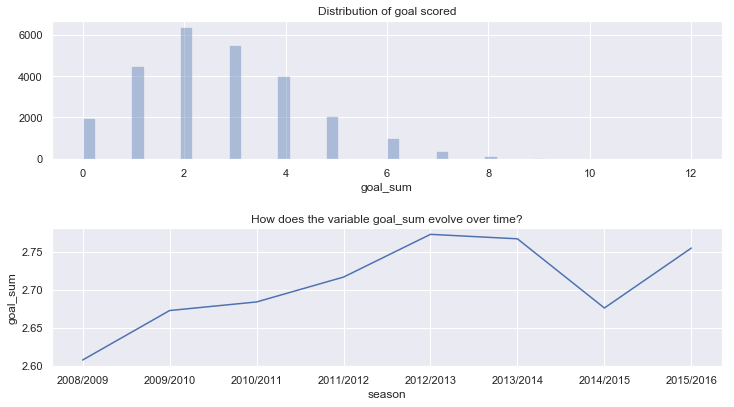

In [29]:
#Plot the distribution of goal_sum and its evolution over the considered timeframe.
plt.figure(figsize=(12,6))
figure, axes = plt.subplots(2, 1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
sns.distplot(match_data['goal_sum'], kde=False, ax=axes[0]).set_title('Distribution of goal scored')
sns.lineplot(x='season',y='goal_sum',data=match_data, err_style=None, ax=axes[1]).set_title('How does the variable goal_sum evolve over time?')

The distribution of goal_sum is positively skewed and the mean is 2.7. It means the on average, during the seasons 2008-2016, for each match 2.7 have been scored.

The variable goal_sum is following an upward trend, which means that the amount of goals scored during the timeframe under analysis has grown.

### **2. In which leagues are matches most likely to end up with three or more goal?**

The variable under analysis is now under_over. The chart below (created using seaborn) shows how the varible is distributed across the major european leagues.

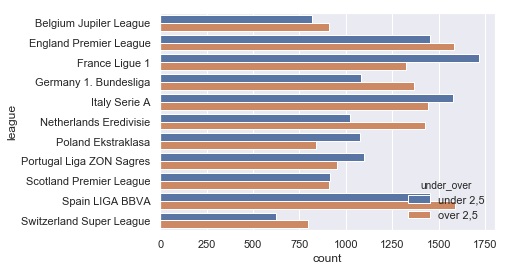

In [18]:
#Plot under_over by league
sns.countplot(y='league',hue='under_over', data=match_data)

In [19]:
#Create table with percentage of matches under_over for each league.
match_data.groupby(by='league')['under_over'].value_counts(normalize=True).sort_values(ascending=False)

league                    under_over
Netherlands Eredivisie    over 2,5      0.582108
France Ligue 1            under 2,5     0.564803
Poland Ekstraklasa        under 2,5     0.561458
Switzerland Super League  over 2,5      0.561181
Germany 1. Bundesliga     over 2,5      0.558415
Portugal Liga ZON Sagres  under 2,5     0.535088
Belgium Jupiler League    over 2,5      0.527778
Italy Serie A             under 2,5     0.522373
Spain LIGA BBVA           over 2,5      0.521711
England Premier League    over 2,5      0.521382
Scotland Premier League   under 2,5     0.500548
                          over 2,5      0.499452
England Premier League    under 2,5     0.478618
Spain LIGA BBVA           under 2,5     0.478289
Italy Serie A             over 2,5      0.477627
Belgium Jupiler League    under 2,5     0.472222
Portugal Liga ZON Sagres  over 2,5      0.464912
Germany 1. Bundesliga     under 2,5     0.441585
Switzerland Super League  under 2,5     0.438819
Poland Ekstraklasa        over 2

As you can see in the table and the chart above, the league that had shown the greatest incidence of matches ended up with 3 or more goals are:
    
1. Netherlands Eredivisie (58%)

2. Switzerland Super League (56%)

3. Germany 1. Bundesliga (56%)

4. Belgium Jupiler League (53%)

5. Spain LIGA BBVA (52%)

### **3. What teams have scored the most?**

In order to find out which teams have scored the most we need to create a new dataframe, which will not take into account the fact that a team play at home or away. To do so we have to select all the matches played at home, then the matches played away and finally concatenate them into a single dataframe.

,goal
team,
FC Barcelona,2.792763
Real Madrid CF,2.773026
FC Bayern Munich,2.400735
PSV,2.397059
Ajax,2.378676


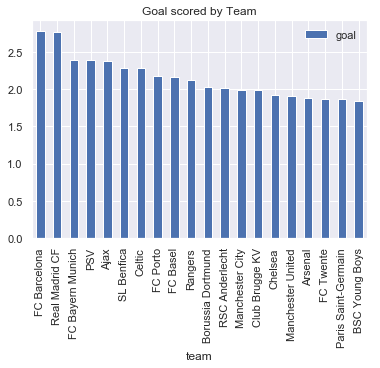

In [20]:
#WHICH TEAM HAVE SCORED THE MOST GOALS?
#CREATING matche_home AND match_away and merge them into match_goal
match_home=match_data.loc[:,('date','home_team','home_team_goal')]
match_home.rename(index=str,columns={'home_team':'team','home_team_goal':'goal'},inplace=True)

match_away=match_data.loc[:,('date','away_team','away_team_goal')]
match_away.rename(index=str,columns={'away_team':'team','away_team_goal':'goal'},inplace=True)

match_goal=pd.concat([match_home, match_away], ignore_index=True)

goal_scored_by_team=match_goal.groupby(by='team')
goal_scored_by_team.mean().sort_values('goal',ascending=False).head(20).plot(kind='bar', title='Goal scored by Team')
goal_scored_by_team.mean().sort_values('goal',ascending=False).head(5)

### **4. Has european football become more or less equilibrated?**

The variable under analysis is now goal_diff which the difference of the goals scored by the two teams. It is assumed to be a measure of competitiveness of a league becouse if the such difference is low, the match is assumed to be more equilibrated. Hence, if a league shows a low goal difference for each match, it is assumed to be more equilibrated and unpredictable.

Text(0.5, 1.0, 'How does the variable goal_diff evolve over time?')

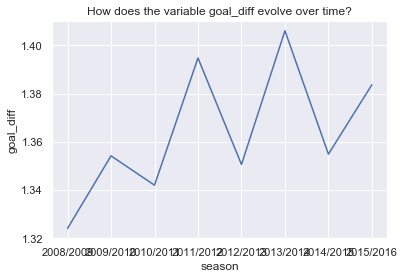

In [21]:
#Plot the distribution of goal_diff and its evolution over the considered timeframe.
sns.lineplot(x='season',y='goal_diff',data=match_data, err_style=None).set_title('How does the variable goal_diff evolve over time?')

During the considered timeframe, the variable goal_diff has grown. It is hard to say if european football has become less equilibrated with the data avaliable here since this upward trend in goal_diff may be caused by a number of factors we are not taking into account in this analysis. It possible to state only that during the period under analysis the difference between the goal scored by the two teams has grown.

But if we assume that goal_diff may be a measure of equilibrium, european football ha become less equilibrated.

### **5. Which are the most equilibrated leagues?**

In this case we are considering the mean of goal_diff to show which league had shown on average a low value of goal_diff, hence they are assumed to be more equilibrated.

,goal_diff
league,
France Ligue 1,1.223355
Poland Ekstraklasa,1.239583
Italy Serie A,1.261850
Portugal Liga ZON Sagres,1.304581
England Premier League,1.355263


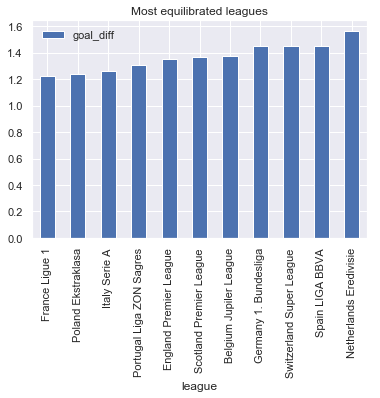

In [22]:
#Most equilibrated leagues.
goal_diff_by_league=match_data.groupby('league')[['league','goal_diff']]
goal_diff_by_league.mean().sort_values('goal_diff',ascending=True).plot(kind='bar', title='Most equilibrated leagues')
goal_diff_by_league.mean().sort_values('goal_diff',ascending=True).head()

In the chart shown above, you can see which are the most equilibrated leagues according to our assumption that the difference of the goals scored by the two teams is a good measure of equilibrium.

### **6. Is there any evidence of home advantage?**

The home advantage is defined as the benefit that the home team is said to gain over the visiting team (https://en.wikipedia.org/wiki/Home_advantage) and it may be due to many different factors that we are not takining into consideration in this analysis. The main goal here is to find ou whether or not there had been evidence of home advantage during the perion under analysis. 

**6.1 Static perspective on home advantage**

In [23]:
#Create Series functional for plotting
serres1X2=match_data['1X2'].value_counts(normalize=True)
serhome1x=match_data['home1X'].value_counts(normalize=True)

serhome1x

yes    0.712614
no     0.287386
Name: home1X, dtype: float64

The 71% of matches had ended up with the home team winning or with a draw.

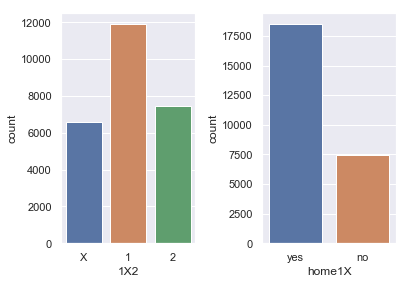

In [24]:
#Plotting Series
f, axes = plt.subplots(1, 2)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
sns.countplot(x='1X2', data=match_data, ax=axes[0])
sns.countplot(x='home1X', data=match_data, ax=axes[1])

During the seasons 2008-2016 most matches ended up win the home team winning or with a draw. The data showed a substatial home advantage.

**6.2 Distribution of goal scored at home**

In [25]:
#Print summary statistics of home_team_goal.
match_data[['home_team_goal','away_team_goal']].describe()

,home_team_goal,away_team_goal
count,25979.000000,25979.000000
mean,1.544594,1.160938
std,1.297158,1.142110
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,9.000000


Text(0.5, 1.0, 'Distribution of away_team_goal')

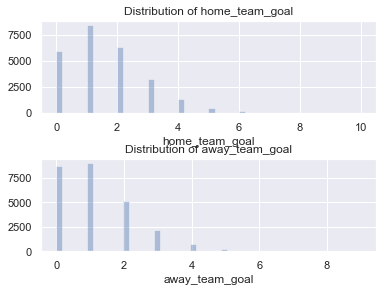

In [26]:
#Plot the distribution of home_team_goal and its evolution over time.
f, axes = plt.subplots(2, 1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
sns.distplot(match_data['home_team_goal'], kde=False, ax=axes[0]).set_title('Distribution of home_team_goal')
sns.distplot(match_data['away_team_goal'], kde=False, ax=axes[1]).set_title('Distribution of away_team_goal')

Acoording to the charts and the table shown above, we can state that: 
- The medians are equal: in 50% of instances, either one team score one goal.
- The means are different: on average the home team scores more than the away team. It may be due to outliers, which are grater for home_team_goal.

**6.3 Evolution of home advantage over time**

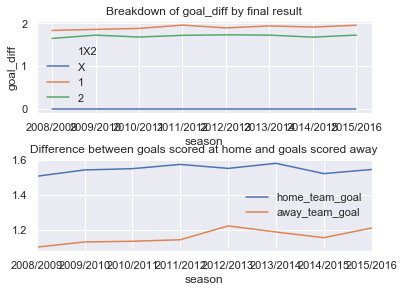

In [27]:
f, axes = plt.subplots(2, 1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
sns.lineplot(x='season', y='goal_diff', hue='1X2', data=match_data, err_style=None, ax=axes[0]).set_title('Breakdown of goal_diff by final result')
match_data.groupby(by='season')[['home_team_goal','away_team_goal']].mean().plot(ax=axes[1], title='Difference between goals scored at home and goals scored away')

- The first chart shows that the goal difference of the matches where the home team won is higher then the one where the away team won. This means the the team that win at home scored more the they won away.

- The second chart shows the most goals are scored at home.

The data showed again a substantial home advantage.

Considering **6.1** and **6.2** it is possible to state that over the seasons 2008-2016 there had been a substantial home advantage.

## **Conclusions**

After analysing the dataset it is now time to draw some conclusions. It is possible to state that during the seasons 2008-2016:



- The amount of goals scored on each match had grown.


- The leagues that had shown the greatest incidence of matches ended up with 3 or more goals are:

    - Netherlands Eredivisie (58%)

    - Switzerland Super League (56%)

    - Germany 1. Bundesliga (56%)

    - Belgium Jupiler League (53%)

    - Spain LIGA BBVA (52%)
    
    
- The teams that on average have scored the most on each match are:
    
    - FC Barcelona (2.8)
    
    - Real Madrid CF	(2.8)
    
    - FC Bayern Munich (2.4)
    
    - PSV	(2.4)
    
    - Ajax (2.4)
    
    
-  The variable goal_diff has grown. It is hard to say if european football has become less equilibrated with the data avaliable here since this upward trend in goal_diff may be caused by a number of factors we are not taking into account in this analysis. But if we assume that goal_diff may be a measure of equilibrium, european football ha become less equilibrated.




- The most equilibrated european leagues are:

    - France Ligue 1	
    
    - Poland Ekstraklasa	
    
    - Italy Serie A	
    
    - Portugal Liga ZON Sagres	
    
    - England Premier League
 
 
 
- The data showed again a substantial home advantage: 

    - The goal difference of the matches where the home team won is higher then the one where the away team won. This means the the team that win at home scored more than the onee that won away.
    
    - The most goals are scored at home.
    
    - 71% of matches had ended up with the home team winning or with a draw.
    
    - On average home team score more at home than away.


**Limitations**

Regarding questions **4 - 5**, they are not providing an exhaustive explaination on the equilibrium of european football. The only variable that has been analyzed is the goal difference, which can had been influenced by many different factors not considered in this analysis (e.g. new rules, weather, etc.). For instance the variable goal_diff may not even reflect the equilibrium, but its growth may be explained saying that since during the period under analysis the average amount of goal scored on each match grew, the upward trend in goal_difference may be a simple consequence of that.


Regarding question **6**, the fact that the data showed a substantial home advantage doeasn't mean that playing at the home field it is an actual advantage, but it can be caused by a number of external factors that we are not taking into account.